# Advanced GraphRAG: Knowledge Graph-Enhanced Retrieval with Neo4j + Qdrant

**Goal**: Implement an advanced GraphRAG pipeline that leverages a Knowledge Graph (Neo4j) to enrich and improve semantic retrieval (Qdrant) on ArXiv scientific papers.

**Key features**:
- Rich Knowledge Graph with typed and weighted relationships
- Multi-hop graph traversal to discover related documents
- Combination of vector search + graph discovery + re-ranking
- Interactive visualization of the graph and reasoning

---

## Architecture Overview

```
Query → Embeddings → Qdrant Vector Search → Top-K Chunks
                                                  ↓
                                          Extract Paper IDs
                                                  ↓
                              Neo4j Multi-Hop Graph Traversal
                                    ↓                    ↓
                          Related Concepts      Graph-Discovered Papers
                                    ↓                    ↓
                              Fetch additional chunks from Qdrant
                                                  ↓
                                    Merge + Re-rank all results
                                                  ↓
                                  Enriched Context → LLM → Answer
```

---

## STEP 1: Setup & Configuration

### 1.1 Libraries import

In [15]:
# Standard libraries
import os
import uuid
import time
import json
from typing import List, Dict, Any, Optional, Tuple
from collections import defaultdict, Counter

# Data manipulation
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Environment variables
from dotenv import load_dotenv

# Pydantic for structured outputs
from pydantic import BaseModel, Field

# LangChain
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate

# Qdrant
from qdrant_client import QdrantClient
from qdrant_client.models import (
    Distance, VectorParams, SparseVectorParams, PointStruct,
    Modifier, Document, Prefetch, FusionQuery, Fusion,
    Filter, FieldCondition, MatchValue, MatchAny
)

# Neo4j
from neo4j import GraphDatabase

# Visualization
import matplotlib.pyplot as plt
from IPython.display import IFrame, display

print("All libraries imported successfully.")

All libraries imported successfully.


### 1.2 Environment Variables configuration

In [2]:
# Load environment variables
load_dotenv()

# OpenAI Configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Qdrant Configuration (Docker local)
QDRANT_URL = "http://localhost:6333"
QDRANT_COLLECTION = "graphrag_papers"

# Neo4j Configuration (Docker local)
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Model Configuration
LLM_MODEL = "gpt-4.1-mini"
EMBEDDING_MODEL = "text-embedding-3-small"  # 1536 dimensions
EMBEDDING_DIMENSION = 1536

# Dataset Configuration
NUM_PAPERS = 500

print(f"Configuration loaded:")
print(f"  LLM Model: {LLM_MODEL}")
print(f"  Embedding Model: {EMBEDDING_MODEL} ({EMBEDDING_DIMENSION}d)")
print(f"  Qdrant URL: {QDRANT_URL}")
print(f"  Neo4j URI: {NEO4J_URI}")
print(f"  Papers to process: {NUM_PAPERS}")

Configuration loaded:
  LLM Model: gpt-4.1-mini
  Embedding Model: text-embedding-3-small (1536d)
  Qdrant URL: http://localhost:6333
  Neo4j URI: bolt://localhost:7687
  Papers to process: 500


### 1.3 Clients and Models initialization

In [3]:
# Initialize OpenAI Embeddings
embeddings = OpenAIEmbeddings(
    model=EMBEDDING_MODEL,
    openai_api_key=OPENAI_API_KEY
)

# Initialize LLM
llm = ChatOpenAI(
    model=LLM_MODEL,
    temperature=0,  # Deterministic
    openai_api_key=OPENAI_API_KEY
)

# Initialize Qdrant client
qdrant_client = QdrantClient(url=QDRANT_URL)

# Initialize Neo4j driver
neo4j_driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
)

# Verify connections
try:
    qdrant_client.get_collections()
    print("Qdrant connection: OK")
except Exception as e:
    print(f"Qdrant connection error: {e}")

try:
    neo4j_driver.verify_connectivity()
    print("Neo4j connection: OK")
except Exception as e:
    print(f"Neo4j connection error: {e}")

# Test embedding
test_emb = embeddings.embed_query("test")
print(f"Embedding dimension: {len(test_emb)}")
print(f"\nAll clients initialized successfully.")

Qdrant connection: OK
Neo4j connection: OK
Embedding dimension: 1536

All clients initialized successfully.


## STEP 2: Data Loading & Preparation

### 2.1 Load ArXiv Papers Dataset

We load 500 ArXiv scientific papers from the `papers_data.csv` file previously generated.
Each paper contains: `paper_id`, `title`, `abstract`, `text` (combined), `full_text`.

In [4]:
# Load papers from CSV
papers_df = pd.read_csv('papers_data.csv')

print(f"Loaded {len(papers_df)} papers")
print(f"\nColumns: {list(papers_df.columns)}")
print(f"\nSample paper:")
print(f"  ID: {papers_df.iloc[0]['paper_id']}")
print(f"  Title: {papers_df.iloc[0]['title'][:100]}...")
print(f"  Abstract length: {len(str(papers_df.iloc[0]['abstract']))} chars")
print(f"  Full text length: {len(str(papers_df.iloc[0]['full_text']))} chars")

papers_df.head()

Loaded 500 papers

Columns: ['paper_id', 'title', 'abstract', 'text', 'full_text']

Sample paper:
  ID: paper_0000
  Title: additive models @xcite provide an important family of models for semiparametric regression or classi...
  Abstract length: 932 chars
  Full text length: 26092 chars


,paper_id,title,abstract,text,full_text
0,paper_0000,additive models @xcite provide an important fa...,additive models play an important role in sem...,Title: additive models @xcite provide an impor...,additive models @xcite provide an important fa...
1,paper_0001,the leptonic decays of a charged pseudoscalar ...,"we have studied the leptonic decay @xmath0 , ...",Title: the leptonic decays of a charged pseudo...,the leptonic decays of a charged pseudoscalar ...
2,paper_0002,the transport properties of nonlinear non - eq...,"in 84 , 258 ( 2000 ) , mateos conjectured tha...",Title: the transport properties of nonlinear n...,the transport properties of nonlinear non - eq...
3,paper_0003,studies of laser beams propagating through tur...,the effect of a random phase diffuser on fluc...,Title: studies of laser beams propagating thro...,studies of laser beams propagating through tur...
4,paper_0004,the so - called `` nucleon spin crisis '' rais...,with a special intention of clarifying the un...,Title: the so - called `` nucleon spin crisis ...,the so - called `` nucleon spin crisis '' rais...


### 2.2 Text Chunking

We split each paper's combined text into chunks of 1000 characters with 200 overlap.
Each chunk preserves metadata (paper_id, title, chunk_index) for traceability.

In [5]:
# Text Splitter initialization
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]
)

all_chunks = []

for idx, paper in tqdm(papers_df.iterrows(), total=len(papers_df), desc="Chunking"):
    # Split the combined text field
    chunks = text_splitter.split_text(str(paper['text']))

    # Add metadata to each chunk
    for chunk_idx, chunk in enumerate(chunks):
        all_chunks.append(
            {
                'chunk_id': f"{paper['paper_id']}_chunk_{chunk_idx}",
                'paper_id': paper['paper_id'],
                'title': paper['title'],
                'chunk_text': chunk,
                'chunk_index': chunk_idx,
                'total_chunks': len(chunks)
            }
        )

chunks_df = pd.DataFrame(all_chunks)

print(f"\nChunk Statistics:")
print(f"  Total chunks: {len(chunks_df)}")
print(f"  Avg chunk length: {chunks_df['chunk_text'].str.len().mean():.0f} chars")
print(f"  Min chunk length: {chunks_df['chunk_text'].str.len().min()} chars")
print(f"  Max chunk length: {chunks_df['chunk_text'].str.len().max()} chars")
print(f"  Avg chunks per paper: {chunks_df.groupby('paper_id').size().mean():.1f}")

Chunking: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 8665.13it/s]


Chunk Statistics:
  Total chunks: 2940
  Avg chunk length: 689 chars
  Min chunk length: 34 chars
  Max chunk length: 1000 chars
  Avg chunks per paper: 5.9


In [6]:
chunks_df.head(10)

,chunk_id,paper_id,title,chunk_text,chunk_index,total_chunks
0,paper_0000_chunk_0,paper_0000,additive models @xcite provide an important fa...,Title: additive models @xcite provide an impor...,0,5
1,paper_0000_chunk_1,paper_0000,additive models @xcite provide an important fa...,Abstract: additive models play an important r...,1,5
2,paper_0000_chunk_2,paper_0000,additive models @xcite provide an important fa...,Content: additive models @xcite provide an imp...,2,5
3,paper_0000_chunk_3,paper_0000,additive models @xcite provide an important fa...,many examples of such estimators belong to the...,3,5
4,paper_0000_chunk_4,paper_0000,additive models @xcite provide an important fa...,this is in sharp contrast to kernel methods ba...,4,5
5,paper_0001_chunk_0,paper_0001,the leptonic decays of a charged pseudoscalar ...,Title: the leptonic decays of a charged pseudo...,0,4
6,paper_0001_chunk_1,paper_0001,the leptonic decays of a charged pseudoscalar ...,Content: the leptonic decays of a charged pseu...,1,4
7,paper_0001_chunk_2,paper_0001,the leptonic decays of a charged pseudoscalar ...,the quantity @xmath13 describes the amplitude ...,2,4
8,paper_0001_chunk_3,paper_0001,the leptonic decays of a charged pseudoscalar ...,"the charm mesons , @xmath27 and @xmath28 , are...",3,4
9,paper_0002_chunk_0,paper_0002,the transport properties of nonlinear non - eq...,Title: the transport properties of nonlinear n...,0,6


## STEP 3: Qdrant Vector Store Setup

We create a single Qdrant collection with **dual vectors** (dense + sparse) to power the vector search component of our GraphRAG pipeline.

**Design choices**:
- **Dense vectors**: OpenAI `text-embedding-3-small` (1536d, COSINE) for semantic similarity
- **Sparse vectors**: Qdrant built-in BM25 with IDF modifier for keyword matching
- **Fusion**: RRF (Reciprocal Rank Fusion) combines both signals at query time

This gives us the best possible vector retrieval as the foundation for graph enrichment.

### 3.1 Create Qdrant Collection

In [7]:
def create_qdrant_collection(collection_name: str, recreate: bool = False):
    """
    Create a Qdrant collection with dense + sparse vectors for hybrid search.

    Args:
        collection_name: Name of the collection
        recreate: If True, delete and recreate the collection if it exists

    Design choices:
    - Distance metric: COSINE (best for normalized embeddings)
    - Vector size: 1536 (text-embedding-3-small dimension)
    - Sparse: BM25 with IDF modifier for keyword relevance
    """
    try:
        # Check if collection exists
        collections = qdrant_client.get_collections().collections
        collection_exists = any(col.name == collection_name for col in collections)

        if collection_exists:
            if recreate:
                qdrant_client.delete_collection(collection_name)
                print(f"Deleted existing collection: {collection_name}")
            else:
                print(f"Collection '{collection_name}' already exists")
                return

        # Create collection with dense + sparse vectors
        qdrant_client.create_collection(
            collection_name=collection_name,
            vectors_config={
                "dense": VectorParams(
                    size=EMBEDDING_DIMENSION,
                    distance=Distance.COSINE
                )
            },
            sparse_vectors_config={
                "sparse": SparseVectorParams(
                    modifier=Modifier.IDF  # BM25 with IDF
                )
            }
        )
        print(f"Created collection: {collection_name}")

    except Exception as e:
        print(f"Error creating collection {collection_name}: {e}")
        raise

create_qdrant_collection(QDRANT_COLLECTION)

Collection 'graphrag_papers' already exists


### 3.2 Embed and Index Documents

We generate dense embeddings (OpenAI) for each chunk and upload them with BM25 sparse vectors to Qdrant.
Batch upload in groups of 50 for efficiency.

In [9]:
# Generate embeddings and prepare points
points = []

for idx, chunk_row in tqdm(chunks_df.iterrows(), total=len(chunks_df), desc="Embedding chunks"):
    dense_vector = embeddings.embed_query(chunk_row['chunk_text'])

    point = PointStruct(
        id=str(uuid.uuid4()),
        vector={
            "dense": dense_vector,
            "sparse": Document(
                text=chunk_row['chunk_text'],
                model="Qdrant/bm25"
            )
        },
        payload={
            'chunk_id': chunk_row['chunk_id'],
            'paper_id': chunk_row['paper_id'],
            'title': chunk_row['title'],
            'chunk_text': chunk_row['chunk_text'],
            'chunk_index': chunk_row['chunk_index'],
            'total_chunks': chunk_row['total_chunks']
        }
    )
    points.append(point)

print(f"\nPrepared {len(points)} points for upload")

Embedding chunks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2940/2940 [09:59<00:00,  4.91it/s]


Prepared 2940 points for upload


In [10]:
# Upload points in batches
UPLOAD_BATCH = 50

for i in tqdm(range(0, len(points), UPLOAD_BATCH), desc="Uploading to Qdrant"):
    batch = points[i:i + UPLOAD_BATCH]
    qdrant_client.upsert(
        collection_name=QDRANT_COLLECTION,
        points=batch
    )

# Verify upload
collection_info = qdrant_client.get_collection(collection_name=QDRANT_COLLECTION)
print(f"\nCollection '{QDRANT_COLLECTION}' stats:")
print(f"  Vectors count: {collection_info.points_count}")
print(f"  Status: {collection_info.status}")

Uploading to Qdrant: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:08<00:00,  6.82it/s]


Collection 'graphrag_papers' stats:
  Vectors count: 2940
  Status: green


### 3.3 Quick Search Test

Verify the collection works with a quick hybrid search before proceeding to graph construction.

In [11]:
# Quick hybrid search test
test_query = "What are kernel methods in machine learning?"
dense_query = embeddings.embed_query(test_query)

response = qdrant_client.query_points(
    collection_name=QDRANT_COLLECTION,
    prefetch=[
        Prefetch(
            query=Document(text=test_query, model="Qdrant/bm25"),
            using="sparse",
            limit=10
        ),
        Prefetch(
            query=dense_query,
            using="dense",
            limit=10
        )
    ],
    query=FusionQuery(fusion=Fusion.RRF),
    limit=5
)

print(f"Query: '{test_query}'")
print(f"Results: {len(response.points)} chunks\n")

for i, point in enumerate(response.points):
    print(f"  [{i+1}] RRF Score: {point.score:.4f}")
    print(f"      Paper: {point.payload['title'][:80]}...")
    print(f"      Chunk: {point.payload['chunk_text'][:120]}...")
    print()

Query: 'What are kernel methods in machine learning?'
Results: 5 chunks

  [1] RRF Score: 0.7500
      Paper: additive models @xcite provide an important family of models for semiparametric ...
      Chunk: this is in sharp contrast to kernel methods based on a lipschitz continuous loss function and on a bounded loss function...

  [2] RRF Score: 0.7000
      Paper: additive models @xcite provide an important family of models for semiparametric ...
      Chunk: Abstract:  additive models play an important role in semiparametric statistics . 
 this paper gives learning rates for r...

  [3] RRF Score: 0.5833
      Paper: model selection is an important problem in many areas including machine learning...
      Chunk: Title: model selection is an important problem in many areas including machine learning .

Abstract:  this paper introdu...

  [4] RRF Score: 0.5333
      Paper: additive models @xcite provide an important family of models for semiparametric ...
      Chunk: many examples of

## STEP 4: Knowledge Graph Construction (Neo4j)

This is where GraphRAG differentiates itself from plain vector search. We build a **rich Knowledge Graph** with:

**Node types**: `Paper`, `Concept`, `Method`, `ResearchArea`

**Relationship types**:
- `MENTIONS_CONCEPT` (Paper → Concept): paper discusses a concept
- `USES_METHOD` (Paper → Method): paper applies a specific method/algorithm
- `BELONGS_TO` (Paper → ResearchArea): paper belongs to a research domain
- `RELATED_TO` (Concept ↔ Concept): concepts co-occur across papers (weighted)
- `APPLIED_IN` (Method → ResearchArea): method is applied in a domain
- `SHARED_METHOD` (Paper ↔ Paper): papers share common methods (weighted)

The key improvement: **cross-paper relationships** (`RELATED_TO`, `APPLIED_IN`, `SHARED_METHOD`) enable multi-hop graph traversal to discover documents that vector search alone would miss.

---

### 4.1 Pydantic Schema for Entity Extraction

We extract more entities per paper (up to 8 concepts, 8 methods, 3 areas) compared to typical approaches, to build a denser and more connected graph.

In [8]:
class Concept(BaseModel):
    """Key scientific concept extracted from a paper"""
    name: str = Field(description="Concept name, lowercase and normalized (e.g., 'kernel methods', 'neural networks', 'dark energy')")
    category: str = Field(description="One of: ML_Method, Math_Concept, Physics_Concept, Statistical_Method, CS_Concept, General")

class Method(BaseModel):
    """Specific algorithm, technique, or methodology"""
    name: str = Field(description="Method name, lowercase and normalized (e.g., 'support vector machine', 'monte carlo simulation', 'gradient descent')")

class ResearchArea(BaseModel):
    """Broad research domain"""
    name: str = Field(description="Research area, lowercase (e.g., 'machine learning', 'quantum physics', 'astrophysics')")

class ExtractedEntities(BaseModel):
    """All entities extracted from an ArXiv paper"""
    concepts: List[Concept] = Field(
        default_factory=list,
        description="Key scientific concepts (max 8)"
    )
    methods: List[Method] = Field(
        default_factory=list,
        description="Specific algorithms/techniques/methodologies used (max 8)"
    )
    research_areas: List[ResearchArea] = Field(
        default_factory=list,
        description="Broad research domains (max 3)"
    )

print("Entity schema defined:")
print(f"  Concept fields: name, category")
print(f"  Method fields: name")
print(f"  ResearchArea fields: name")

Entity schema defined:
  Concept fields: name, category
  Method fields: name
  ResearchArea fields: name


### 4.2 LLM Entity Extraction Chain

We use GPT-4.1-mini with structured output to extract entities from each paper. The prompt emphasizes **normalization** (lowercase, consistent naming) to maximize entity merging across papers.

In [9]:
# LLM with structured output for entity extraction
extractor_llm = llm.with_structured_output(ExtractedEntities)

extraction_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are an expert at extracting structured entities from ArXiv scientific papers.
Your goal is to extract entities that will form a Knowledge Graph, so CONSISTENCY and NORMALIZATION are critical.

Rules:
- All names must be LOWERCASE and normalized (e.g., "support vector machine" not "SVM" or "Support Vector Machines")
- Use singular forms when possible (e.g., "neural network" not "neural networks")
- Merge synonyms into a single canonical name (e.g., "deep learning" not "DL")
- Be specific: "convolutional neural network" is better than just "neural network" if the paper is specifically about CNNs

Extract the following:

**Concepts** (max 8): Key scientific concepts, theories, phenomena discussed in the paper.
  - Examples: "kernel methods", "dark energy", "quantum entanglement", "bayesian inference"
  - Categorize each as: ML_Method, Math_Concept, Physics_Concept, Statistical_Method, CS_Concept, or General

**Methods** (max 8): Specific algorithms, techniques, models, or methodologies USED or PROPOSED.
  - Examples: "support vector machine", "monte carlo simulation", "gradient descent", "principal component analysis"
  - Focus on actionable techniques, not abstract concepts

**Research Areas** (max 3): Broad research domains the paper belongs to.
  - Examples: "machine learning", "condensed matter physics", "astrophysics", "natural language processing"
  - Use well-established field names"""
        ),
        (
            "human",
            """Extract entities from this ArXiv paper:

<PAPER>
{content}
</PAPER>"""
        )
    ]
)

# Build the extraction chain
extraction_chain = extraction_prompt | extractor_llm

### 4.3 Extract Entities from All Papers

In [14]:
all_extractions = []
failed_papers = []

for idx, paper in tqdm(papers_df.iterrows(), total=len(papers_df), desc="Extracting entities"):
    try:
        extracted = extraction_chain.invoke({
            "content": paper['text'][:2000]
        })

        all_extractions.append({
            'paper_id': paper['paper_id'],
            'title': paper['title'],
            'entities': extracted,
        })
    except Exception as e:
        print(f"Error on {paper['paper_id']}: {e}")
        failed_papers.append(paper['paper_id'])
        continue

    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{len(papers_df)} papers...")

print(f"\nExtracted entities from {len(all_extractions)}/{len(papers_df)} papers")
if failed_papers:
    print(f"Failed: {len(failed_papers)} papers")

# Statistics
total_concepts = sum(len(e['entities'].concepts) for e in all_extractions)
total_methods = sum(len(e['entities'].methods) for e in all_extractions)
total_areas = sum(len(e['entities'].research_areas) for e in all_extractions)

print(f"\nTotal entities extracted:")
print(f"  Concepts: {total_concepts} (avg {total_concepts/len(all_extractions):.1f} per paper)")
print(f"  Methods: {total_methods} (avg {total_methods/len(all_extractions):.1f} per paper)")
print(f"  Research Areas: {total_areas} (avg {total_areas/len(all_extractions):.1f} per paper)")
print(f"  Total: {total_concepts + total_methods + total_areas}")

Extracting entities:  10%|████████████████▋                                                                                                                                                      | 50/500 [02:26<21:00,  2.80s/it]

  Processed 50/500 papers...


Extracting entities:  20%|█████████████████████████████████▏                                                                                                                                    | 100/500 [04:55<18:20,  2.75s/it]

  Processed 100/500 papers...


Extracting entities:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 150/500 [07:24<15:20,  2.63s/it]

  Processed 150/500 papers...


Extracting entities:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 200/500 [09:54<13:52,  2.77s/it]

  Processed 200/500 papers...


Extracting entities:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 250/500 [12:29<13:10,  3.16s/it]

  Processed 250/500 papers...


Extracting entities:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 300/500 [15:07<09:27,  2.84s/it]

  Processed 300/500 papers...


Extracting entities:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 350/500 [17:45<07:11,  2.88s/it]

  Processed 350/500 papers...


Extracting entities:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 400/500 [20:35<04:57,  2.98s/it]

  Processed 400/500 papers...


Extracting entities:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 450/500 [23:03<02:45,  3.31s/it]

  Processed 450/500 papers...


Extracting entities: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [25:17<00:00,  3.04s/it]

  Processed 500/500 papers...

Extracted entities from 500/500 papers

Total entities extracted:
  Concepts: 3908 (avg 7.8 per paper)
  Methods: 1809 (avg 3.6 per paper)
  Research Areas: 1197 (avg 2.4 per paper)
  Total: 6914


### 4.4 Entity Distribution Visualization

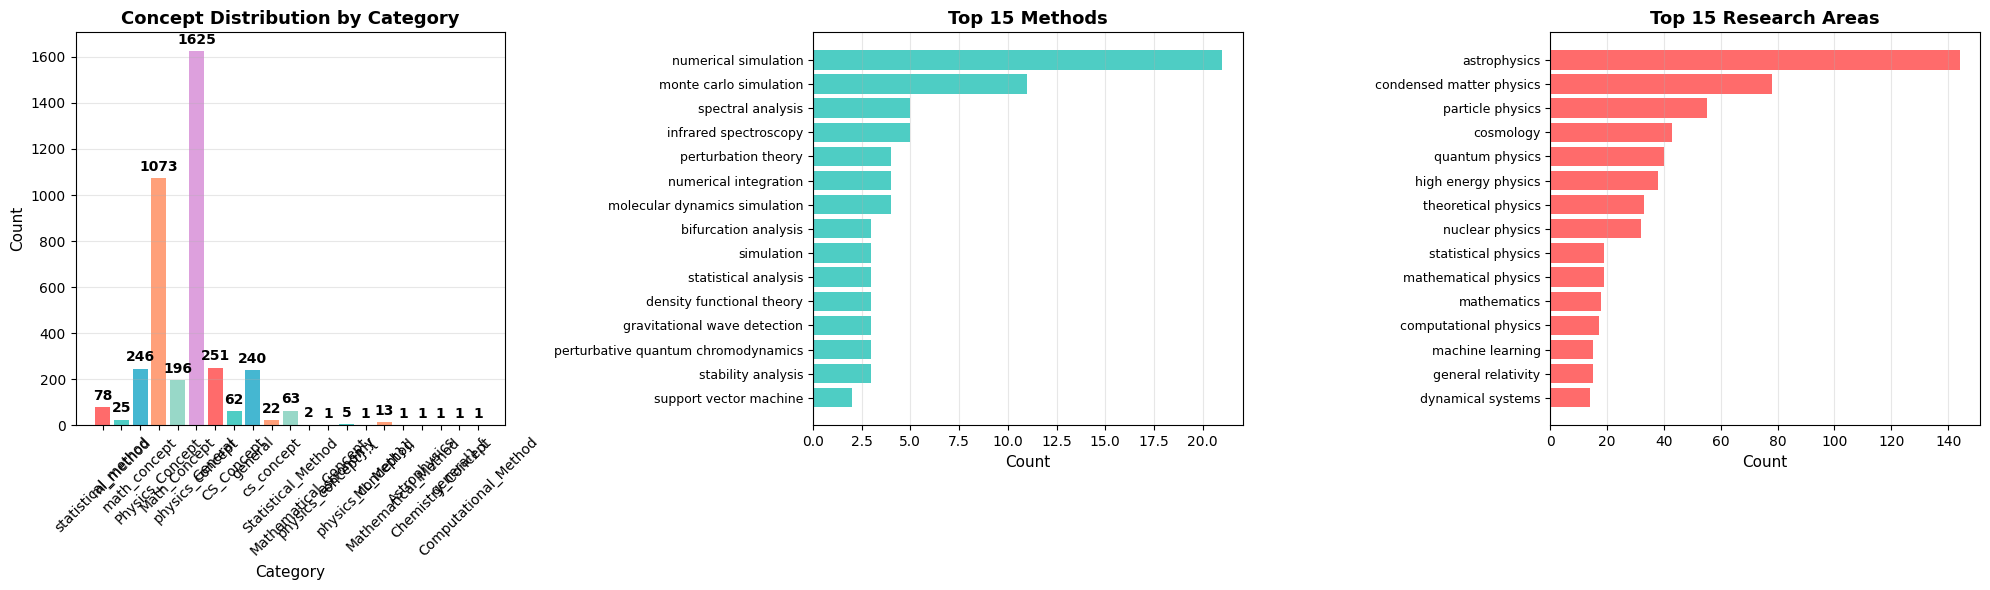


Unique entities:
  Unique concepts: 3294
  Unique methods: 1700
  Unique research areas: 261


In [15]:
# Concept categories distribution
categories = Counter()
for e in all_extractions:
    for concept in e['entities'].concepts:
        categories[concept.category] += 1

# Top methods and research areas
method_counter = Counter()
area_counter = Counter()
for e in all_extractions:
    for m in e['entities'].methods:
        method_counter[m.name] += 1
    for a in e['entities'].research_areas:
        area_counter[a.name] += 1

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Concept categories bar chart
cat_names = list(categories.keys())
cat_counts = list(categories.values())
colors_cat = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#DDA0DD']
axes[0].bar(cat_names, cat_counts, color=colors_cat[:len(cat_names)])
axes[0].set_title('Concept Distribution by Category', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
for i, count in enumerate(cat_counts):
    axes[0].text(i, count + max(cat_counts) * 0.02, str(count), ha='center', fontweight='bold')

# 2. Top 15 methods
top_methods = method_counter.most_common(15)
m_names, m_counts = zip(*top_methods)
axes[1].barh(range(len(m_names)), m_counts, color='#4ECDC4')
axes[1].set_yticks(range(len(m_names)))
axes[1].set_yticklabels(m_names, fontsize=9)
axes[1].set_title('Top 15 Methods', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Count', fontsize=11)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# 3. Top 15 research areas
top_areas = area_counter.most_common(15)
a_names, a_counts = zip(*top_areas)
axes[2].barh(range(len(a_names)), a_counts, color='#FF6B6B')
axes[2].set_yticks(range(len(a_names)))
axes[2].set_yticklabels(a_names, fontsize=9)
axes[2].set_title('Top 15 Research Areas', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Count', fontsize=11)
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nUnique entities:")
print(f"  Unique concepts: {len(set(c.name for e in all_extractions for c in e['entities'].concepts))}")
print(f"  Unique methods: {len(method_counter)}")
print(f"  Unique research areas: {len(area_counter)}")

### 4.5 Neo4j Ingestion - Build the Knowledge Graph

We create all nodes and direct relationships (Paper → Concept, Paper → Method, Paper → ResearchArea).

In [17]:
def create_graph(tx, paper_id, title, entities):
    """
    Create nodes and relationships for a single paper.

    Args:
        tx: Neo4j transaction
        paper_id: Unique paper identifier
        title: Paper title
        entities: ExtractedEntities object with concepts, methods, research_areas
    """
    # 1. Create Paper node
    tx.run("""
        MERGE (p:Paper {id: $paper_id})
        SET p.title = $title
    """, paper_id=paper_id, title=title)

    # 2. Create Concept nodes + MENTIONS_CONCEPT relationships
    for concept in entities.concepts:
        tx.run("""
            MERGE (c:Concept {name: $name})
            SET c.category = $category
            WITH c
            MATCH (p:Paper {id: $paper_id})
            MERGE (p)-[:MENTIONS_CONCEPT]->(c)
        """, name=concept.name, category=concept.category, paper_id=paper_id)

    # 3. Create Method nodes + USES_METHOD relationships
    for method in entities.methods:
        tx.run("""
            MERGE (m:Method {name: $name})
            WITH m
            MATCH (p:Paper {id: $paper_id})
            MERGE (p)-[:USES_METHOD]->(m)
        """, name=method.name, paper_id=paper_id)

    # 4. Create ResearchArea nodes + BELONGS_TO relationships
    for area in entities.research_areas:
        tx.run("""
            MERGE (r:ResearchArea {name: $name})
            WITH r
            MATCH (p:Paper {id: $paper_id})
            MERGE (p)-[:BELONGS_TO]->(r)
        """, name=area.name, paper_id=paper_id)

# Clear existing data
print("Clearing existing Neo4j data...")
with neo4j_driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

# Ingest all papers
print("Ingesting papers into Neo4j...")
with neo4j_driver.session() as session:
    for extraction in tqdm(all_extractions, desc="Neo4j ingestion"):
        session.execute_write(
            create_graph,
            paper_id=extraction['paper_id'],
            title=extraction['title'],
            entities=extraction['entities']
        )

print("\nBase Knowledge Graph created!")

Clearing existing Neo4j data...
Ingesting papers into Neo4j...


Neo4j ingestion: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.54it/s]


Base Knowledge Graph created!


### 4.6 Build Cross-Paper Relationships

This is the **critical step** that makes the graph truly useful. We create three types of derived relationships:

1. **RELATED_TO** (Concept ↔ Concept): Concepts that co-occur in the same paper, weighted by frequency
2. **APPLIED_IN** (Method → ResearchArea): Methods linked to the domains where they are used
3. **SHARED_METHOD** (Paper ↔ Paper): Papers connected by shared methods, weighted by count

These cross-links enable **multi-hop traversal**: from a query result, we can walk the graph to discover papers that share methods or related concepts.

In [18]:
with neo4j_driver.session() as session:

    # 1. RELATED_TO: Concepts co-occurring in the same paper (threshold >= 2 papers)
    result = session.run("""
        MATCH (p:Paper)-[:MENTIONS_CONCEPT]->(c1:Concept)
        MATCH (p)-[:MENTIONS_CONCEPT]->(c2:Concept)
        WHERE c1.name < c2.name
        WITH c1, c2, count(DISTINCT p) as co_occurrences
        WHERE co_occurrences >= 2
        MERGE (c1)-[r:RELATED_TO]-(c2)
        SET r.strength = co_occurrences
        RETURN count(r) as created
    """)
    related_count = result.single()['created']
    print(f"1. RELATED_TO (Concept-Concept): {related_count} relationships")

    # 2. APPLIED_IN: Method linked to ResearchArea through papers that use both
    result = session.run("""
        MATCH (p:Paper)-[:USES_METHOD]->(m:Method)
        MATCH (p)-[:BELONGS_TO]->(r:ResearchArea)
        WITH m, r, count(DISTINCT p) as usage_count
        WHERE usage_count >= 1
        MERGE (m)-[rel:APPLIED_IN]->(r)
        SET rel.paper_count = usage_count
        RETURN count(rel) as created
    """)
    applied_count = result.single()['created']
    print(f"2. APPLIED_IN (Method-ResearchArea): {applied_count} relationships")

    # 3. SHARED_METHOD: Papers sharing at least 2 common methods
    result = session.run("""
        MATCH (p1:Paper)-[:USES_METHOD]->(m:Method)<-[:USES_METHOD]-(p2:Paper)
        WHERE p1.id < p2.id
        WITH p1, p2, count(DISTINCT m) as shared_methods, collect(DISTINCT m.name) as method_names
        WHERE shared_methods >= 2
        MERGE (p1)-[r:SHARED_METHOD]-(p2)
        SET r.count = shared_methods, r.methods = method_names
        RETURN count(r) as created
    """)
    shared_count = result.single()['created']
    print(f"3. SHARED_METHOD (Paper-Paper): {shared_count} relationships")

print(f"\nCross-paper relationship construction complete!")

1. RELATED_TO (Concept-Concept): 87 relationships
2. APPLIED_IN (Method-ResearchArea): 4355 relationships
3. SHARED_METHOD (Paper-Paper): 1 relationships

Cross-paper relationship construction complete!


### 4.7 Knowledge Graph Statistics

In [10]:
with neo4j_driver.session() as session:
    # Node counts
    result = session.run("""
        MATCH (n)
        RETURN labels(n)[0] as label, count(*) as count
        ORDER BY count DESC
    """)
    print("Neo4j Knowledge Graph Statistics:")
    print("\nNodes:")
    for record in result:
        print(f"  {record['label']}: {record['count']}")

    # Relationship counts
    rel_result = session.run("""
        MATCH ()-[r]->()
        RETURN type(r) as rel_type, count(*) as count
        ORDER BY count DESC
    """)
    print("\nRelationships:")
    for record in rel_result:
        print(f"  {record['rel_type']}: {record['count']}")

    # Graph density: avg connections per paper
    density_result = session.run("""
        MATCH (p:Paper)
        OPTIONAL MATCH (p)-[r]-()
        WITH p, count(r) as connections
        RETURN avg(connections) as avg_connections,
               min(connections) as min_connections,
               max(connections) as max_connections
    """)
    d = density_result.single()
    print(f"\nGraph density:")
    print(f"  Avg connections per paper: {d['avg_connections']:.1f}")
    print(f"  Min: {d['min_connections']}, Max: {d['max_connections']}")

    # Top connected concepts
    top_concepts = session.run("""
        MATCH (c:Concept)<-[:MENTIONS_CONCEPT]-(p:Paper)
        WITH c, count(p) as paper_count
        ORDER BY paper_count DESC
        LIMIT 10
        RETURN c.name as concept, c.category as category, paper_count
    """)
    print(f"\nTop 10 most connected concepts:")
    for record in top_concepts:
        print(f"  {record['concept']} ({record['category']}): {record['paper_count']} papers")

Neo4j Knowledge Graph Statistics:

Nodes:
  Concept: 3294
  Method: 1700
  Paper: 500
  ResearchArea: 261

Relationships:
  APPLIED_IN: 4355
  MENTIONS_CONCEPT: 3908
  USES_METHOD: 1809
  BELONGS_TO: 1197
  RELATED_TO: 87
  SHARED_METHOD: 1

Graph density:
  Avg connections per paper: 13.8
  Min: 8, Max: 19

Top 10 most connected concepts:
  standard model (physics_concept): 16 papers
  active galactic nucleus (physics_concept): 12 papers
  black hole (physics_concept): 11 papers
  dark matter (physics_concept): 11 papers
  gravitational wave (physics_concept): 10 papers
  quantum chromodynamics (physics_concept): 10 papers
  superconductivity (Physics_Concept): 9 papers
  phase transition (physics_concept): 8 papers
  higgs boson (physics_concept): 8 papers
  cp violation (physics_concept): 7 papers


## STEP 5: GraphRAG Retrieval Pipeline

The core of GraphRAG: we combine **Qdrant hybrid search** with **Neo4j multi-hop graph traversal** to retrieve more relevant and diverse context than vector search alone.

**Pipeline flow**:
1. **Hybrid Search** (Qdrant): Dense + BM25 + RRF → top-k initial chunks
2. **Graph Traversal** (Neo4j): From initial papers, walk 2 hops to discover related papers via shared concepts/methods
3. **Graph-Discovered Retrieval** (Qdrant): Fetch chunks from graph-discovered papers
4. **Merge + Re-rank**: Combine initial + discovered results, deduplicate, score by relevance
5. **Enriched Context**: Attach graph metadata (concepts, methods, relationships) to the final context
6. **LLM Generation**: Answer with graph-enriched context

---

### 5.1 Hybrid Search Function (Qdrant)

Base retrieval using dense + sparse vectors with RRF fusion. This is the starting point of our GraphRAG pipeline.

In [11]:
def hybrid_search(query: str, top_k: int = 5, paper_ids_filter: List[str] = None) -> list:
    """
    Qdrant hybrid search: Dense + Sparse (BM25) + RRF fusion.

    Args:
        query: Search query
        top_k: Number of results to return
        paper_ids_filter: Optional list of paper_ids to restrict search to

    Returns:
        List of scored points from Qdrant
    """
    dense_query = embeddings.embed_query(query)

    # Build optional filter for paper_ids
    search_filter = None
    if paper_ids_filter:
        search_filter = Filter(
            must=[
                FieldCondition(
                    key="paper_id",
                    match=MatchAny(any=paper_ids_filter)
                )
            ]
        )

    response = qdrant_client.query_points(
        collection_name=QDRANT_COLLECTION,
        prefetch=[
            Prefetch(
                query=Document(text=query, model="Qdrant/bm25"),
                using="sparse",
                limit=top_k * 2,
                filter=search_filter
            ),
            Prefetch(
                query=dense_query,
                using="dense",
                limit=top_k * 2,
                filter=search_filter
            )
        ],
        query=FusionQuery(fusion=Fusion.RRF),
        limit=top_k
    )

    return response.points

# Quick test
test_results = hybrid_search("kernel methods in machine learning", top_k=3)
print(f"Hybrid search test: {len(test_results)} results")
for r in test_results:
    print(f"  [{r.score:.4f}] {r.payload['title'][:80]}...")

Hybrid search test: 3 results
  [0.7500] additive models @xcite provide an important family of models for semiparametric ...
  [0.6667] additive models @xcite provide an important family of models for semiparametric ...
  [0.5333] additive models @xcite provide an important family of models for semiparametric ...


### 5.2 Multi-Hop Graph Traversal (Neo4j)

This is where GraphRAG shines. Starting from the papers found by vector search, we traverse the Knowledge Graph to:

1. **Hop 1**: Get all concepts and methods of the initial papers
2. **Hop 2**: Find OTHER papers that share those concepts/methods (graph-discovered papers)
3. **Collect graph context**: Related concepts, shared methods, research areas, and traversal paths

The graph discovers papers that are **semantically related through knowledge structure**, not just embedding similarity.

In [12]:
def graph_traversal(paper_ids: List[str], max_discovered: int = 5) -> Dict[str, Any]:
    """
    Multi-hop graph traversal starting from initial paper IDs.

    Traversal strategy:
    - Hop 1: Paper → Concepts, Methods, ResearchAreas
    - Hop 2: Concepts/Methods → Other Papers (graph-discovered)
    - Also follows RELATED_TO, APPLIED_IN, SHARED_METHOD edges

    Args:
        paper_ids: Paper IDs from initial vector search
        max_discovered: Max number of graph-discovered papers to return

    Returns:
        Dict with graph_context (metadata for initial papers) and
        discovered_paper_ids (new papers found through graph traversal)
    """
    with neo4j_driver.session() as session:

        # 1. Get full graph context for initial papers
        context_result = session.run("""
            MATCH (p:Paper)
            WHERE p.id IN $paper_ids

            // Hop 1: Direct entities
            OPTIONAL MATCH (p)-[:MENTIONS_CONCEPT]->(c:Concept)
            OPTIONAL MATCH (p)-[:USES_METHOD]->(m:Method)
            OPTIONAL MATCH (p)-[:BELONGS_TO]->(r:ResearchArea)

            // Hop 2: Related concepts via co-occurrence
            OPTIONAL MATCH (c)-[rel:RELATED_TO]-(rc:Concept)

            RETURN p.id as paper_id,
                   p.title as title,
                   collect(DISTINCT {name: c.name, category: c.category}) as concepts,
                   collect(DISTINCT m.name) as methods,
                   collect(DISTINCT r.name) as research_areas,
                   collect(DISTINCT {name: rc.name, strength: rel.strength}) as related_concepts
        """, paper_ids=paper_ids)

        graph_context = {}
        for record in context_result:
            graph_context[record['paper_id']] = {
                'title': record['title'],
                'concepts': [c for c in record['concepts'] if c['name'] is not None],
                'methods': [m for m in record['methods'] if m is not None],
                'research_areas': [r for r in record['research_areas'] if r is not None],
                'related_concepts': [
                    rc for rc in record['related_concepts'] if rc['name'] is not None
                ]
            }

        # 2. Discover NEW papers through multi-hop traversal
        # Path: Initial Papers → shared Concepts/Methods → Other Papers
        discovery_result = session.run("""
            // Via shared concepts (2-hop)
            MATCH (p:Paper)-[:MENTIONS_CONCEPT]->(c:Concept)<-[:MENTIONS_CONCEPT]-(discovered:Paper)
            WHERE p.id IN $paper_ids AND NOT discovered.id IN $paper_ids
            WITH discovered, count(DISTINCT c) as shared_concepts, 'concept' as path_type,
                 collect(DISTINCT c.name)[..5] as via_entities

            RETURN discovered.id as paper_id,
                   discovered.title as title,
                   shared_concepts as relevance_score,
                   path_type,
                   via_entities
            ORDER BY relevance_score DESC
            LIMIT $max_discovered

            UNION

            // Via shared methods (2-hop)
            MATCH (p:Paper)-[:USES_METHOD]->(m:Method)<-[:USES_METHOD]-(discovered:Paper)
            WHERE p.id IN $paper_ids AND NOT discovered.id IN $paper_ids
            WITH discovered, count(DISTINCT m) as shared_methods, 'method' as path_type,
                 collect(DISTINCT m.name)[..5] as via_entities

            RETURN discovered.id as paper_id,
                   discovered.title as title,
                   shared_methods as relevance_score,
                   path_type,
                   via_entities
            ORDER BY relevance_score DESC
            LIMIT $max_discovered

            UNION

            // Via SHARED_METHOD direct relationships
            MATCH (p:Paper)-[sm:SHARED_METHOD]-(discovered:Paper)
            WHERE p.id IN $paper_ids AND NOT discovered.id IN $paper_ids
            RETURN discovered.id as paper_id,
                   discovered.title as title,
                   sm.count as relevance_score,
                   'shared_method_edge' as path_type,
                   sm.methods as via_entities
            ORDER BY relevance_score DESC
            LIMIT $max_discovered
        """, paper_ids=paper_ids, max_discovered=max_discovered)

        # Aggregate discovered papers, keeping the best score per paper
        discovered = {}
        for record in discovery_result:
            pid = record['paper_id']
            if pid not in discovered or record['relevance_score'] > discovered[pid]['relevance_score']:
                discovered[pid] = {
                    'paper_id': pid,
                    'title': record['title'],
                    'relevance_score': record['relevance_score'],
                    'path_type': record['path_type'],
                    'via_entities': record['via_entities']
                }

        # Sort by relevance and take top N
        discovered_list = sorted(
            discovered.values(),
            key=lambda x: x['relevance_score'],
            reverse=True
        )[:max_discovered]

    return {
        'graph_context': graph_context,
        'discovered_papers': discovered_list,
        'discovered_paper_ids': [d['paper_id'] for d in discovered_list]
    }

# Quick test
test_ids = [test_results[0].payload['paper_id']]
traversal = graph_traversal(test_ids, max_discovered=3)

print(f"Graph traversal from paper: {test_ids[0]}")
print(f"\nGraph context:")
for pid, ctx in traversal['graph_context'].items():
    print(f"  Concepts: {[c['name'] for c in ctx['concepts'][:5]]}")
    print(f"  Methods: {ctx['methods'][:5]}")
    print(f"  Areas: {ctx['research_areas']}")

print(f"\nDiscovered papers: {len(traversal['discovered_papers'])}")
for d in traversal['discovered_papers']:
    print(f"  [{d['path_type']}, score={d['relevance_score']}] {d['title'][:70]}...")
    print(f"    via: {d['via_entities'][:3]}")

Graph traversal from paper: paper_0000

Graph context:
  Concepts: ['support vector machine', 'rate of convergence', 'gaussian radial basis function kernel', 'reproducing kernel hilbert space', 'quantile regression']
  Methods: ['quantile regression', 'support vector machine', 'regularized kernel method']
  Areas: ['statistics', 'machine learning']

Discovered papers: 1
  [method, score=1] classification problem is one of the most important tasks in time seri...
    via: ['support vector machine']


### 5.3 Complete GraphRAG Pipeline

The full pipeline combines all components:
1. Hybrid search → initial chunks
2. Graph traversal → discover related papers + collect graph metadata
3. Fetch chunks from discovered papers (filtered hybrid search)
4. Merge all chunks, deduplicate, build enriched context with graph info
5. LLM generation with graph-enriched prompt

In [13]:
def graphrag_answer(query: str, top_k: int = 5, graph_discovered_k: int = 5) -> Dict[str, Any]:
    """
    Complete GraphRAG pipeline: Hybrid Search + Multi-Hop Graph Traversal + LLM.

    Args:
        query: User question
        top_k: Number of initial chunks from hybrid search
        graph_discovered_k: Number of additional papers to discover via graph

    Returns:
        Dict with answer, retrieved docs, graph info, and timing metrics
    """
    start_time = time.time()

    # ---- STEP 1: Hybrid Search (Qdrant) ----
    initial_chunks = hybrid_search(query, top_k=top_k)
    retrieval_time = time.time() - start_time

    # Extract unique paper IDs from initial results
    initial_paper_ids = list(set([p.payload['paper_id'] for p in initial_chunks]))

    # ---- STEP 2: Multi-Hop Graph Traversal (Neo4j) ----
    graph_start = time.time()
    traversal_result = graph_traversal(initial_paper_ids, max_discovered=graph_discovered_k)
    graph_time = time.time() - graph_start

    graph_context = traversal_result['graph_context']
    discovered_papers = traversal_result['discovered_papers']
    discovered_ids = traversal_result['discovered_paper_ids']

    # ---- STEP 3: Fetch chunks from graph-discovered papers (Qdrant) ----
    discovered_chunks = []
    if discovered_ids:
        discovered_chunks = hybrid_search(
            query,
            top_k=top_k,
            paper_ids_filter=discovered_ids
        )

    # ---- STEP 4: Merge + Deduplicate ----
    seen_chunk_ids = set()
    all_results = []

    # Initial chunks (higher priority)
    for chunk in initial_chunks:
        cid = chunk.payload['chunk_id']
        if cid not in seen_chunk_ids:
            seen_chunk_ids.add(cid)
            all_results.append({
                'chunk_text': chunk.payload['chunk_text'],
                'title': chunk.payload['title'],
                'paper_id': chunk.payload['paper_id'],
                'score': chunk.score,
                'source': 'hybrid_search'
            })

    # Graph-discovered chunks
    for chunk in discovered_chunks:
        cid = chunk.payload['chunk_id']
        if cid not in seen_chunk_ids:
            seen_chunk_ids.add(cid)
            # Find which path led to this paper
            discovery_info = next(
                (d for d in discovered_papers if d['paper_id'] == chunk.payload['paper_id']),
                None
            )
            all_results.append({
                'chunk_text': chunk.payload['chunk_text'],
                'title': chunk.payload['title'],
                'paper_id': chunk.payload['paper_id'],
                'score': chunk.score * 0.9,  # Slight discount for graph-discovered
                'source': 'graph_discovery',
                'discovery_path': discovery_info
            })

    # Sort by score
    all_results.sort(key=lambda x: x['score'], reverse=True)

    # ---- STEP 5: Build Enriched Context ----
    context_parts = []

    for i, result in enumerate(all_results[:top_k + graph_discovered_k]):
        paper_id = result['paper_id']
        g_info = graph_context.get(paper_id, {})

        context_part = f"[Document {i+1}] (Score: {result['score']:.3f}, Source: {result['source']})\n"
        context_part += f"Paper: {result['title']}\n"
        context_part += f"Content: {result['chunk_text']}\n"

        # Graph enrichment
        if g_info:
            concepts = [c['name'] for c in g_info.get('concepts', [])]
            if concepts:
                context_part += f"Key Concepts: {', '.join(concepts[:6])}\n"

            methods = g_info.get('methods', [])
            if methods:
                context_part += f"Methods Used: {', '.join(methods[:5])}\n"

            related = [rc['name'] for rc in g_info.get('related_concepts', [])]
            if related:
                context_part += f"Related Concepts (via graph): {', '.join(related[:5])}\n"

            areas = g_info.get('research_areas', [])
            if areas:
                context_part += f"Research Areas: {', '.join(areas)}\n"

        # Show discovery path for graph-discovered docs
        if result['source'] == 'graph_discovery' and result.get('discovery_path'):
            dp = result['discovery_path']
            context_part += f"Graph Path: discovered via {dp['path_type']} → {dp['via_entities'][:3]}\n"

        context_parts.append(context_part)

    context = "\n---\n".join(context_parts)

    # ---- STEP 6: LLM Generation ----
    prompt = f"""You are a research assistant with access to scientific papers AND a Knowledge Graph.
The context below includes paper content enriched with graph-derived information:
concepts, methods, related concepts (connected through co-occurrence), and research areas.

Use ALL available information to provide a comprehensive, well-structured answer.

Context:
{context}

Question: {query}

Instructions:
- Answer based ONLY on the provided context
- Leverage the graph information (concepts, methods, relationships) to provide deeper insights
- When relevant, mention connections between papers or concepts discovered through the graph
- Cite which document(s) you used [Document N]
- Be concise but thorough

Answer:"""

    generation_start = time.time()
    response = llm.invoke(prompt).content
    generation_time = time.time() - generation_start

    total_time = time.time() - start_time

    return {
        'query': query,
        'answer': response,
        'retrieved_docs': all_results,
        'graph_context': graph_context,
        'discovered_papers': discovered_papers,
        'context': context,
        'metrics': {
            'retrieval_time_ms': retrieval_time * 1000,
            'graph_traversal_time_ms': graph_time * 1000,
            'generation_time_ms': generation_time * 1000,
            'total_time_ms': total_time * 1000,
            'initial_chunks': len(initial_chunks),
            'graph_discovered_chunks': len(discovered_chunks),
            'total_chunks_used': len(all_results),
            'initial_papers': len(initial_paper_ids),
            'discovered_papers': len(discovered_ids),
            'total_papers': len(initial_paper_ids) + len(discovered_ids),
            'method': 'graphrag_hybrid_multihop'
        }
    }

### 5.4 Test the Pipeline

Let's test with a query that benefits from graph traversal - a question that spans multiple related concepts.

In [14]:
# Test query
test_query = "What is the relationship between kernel methods and support vector machines, and how do they relate to additive models?"

result = graphrag_answer(test_query, top_k=5, graph_discovered_k=5)

# Display answer
print(f"Query: {result['query']}\n")
print(f"Answer:\n{result['answer']}\n")

# Display metrics
m = result['metrics']
print(f"--- Pipeline Metrics ---")
print(f"  Hybrid retrieval: {m['retrieval_time_ms']:.0f} ms")
print(f"  Graph traversal:  {m['graph_traversal_time_ms']:.0f} ms")
print(f"  LLM generation:   {m['generation_time_ms']:.0f} ms")
print(f"  Total:            {m['total_time_ms']:.0f} ms")
print(f"\n  Initial chunks:        {m['initial_chunks']}")
print(f"  Graph-discovered:      {m['graph_discovered_chunks']}")
print(f"  Total chunks used:     {m['total_chunks_used']}")
print(f"  Initial papers:        {m['initial_papers']}")
print(f"  Discovered papers:     {m['discovered_papers']}")
print(f"  Total papers:          {m['total_papers']}")

# Show document sources
print(f"\n--- Document Sources ---")
for i, doc in enumerate(result['retrieved_docs'][:10]):
    source_tag = "VECTOR" if doc['source'] == 'hybrid_search' else "GRAPH"
    print(f"  [{i+1}] [{source_tag}] [{doc['paper_id']}] {doc['title'][:70]}... (score: {doc['score']:.3f})")
    if doc.get('discovery_path'):
        dp = doc['discovery_path']
        print(f"        discovered via {dp['path_type']}: {dp['via_entities'][:3]}")

Query: What is the relationship between kernel methods and support vector machines, and how do they relate to additive models?

Answer:
Kernel methods and support vector machines (SVMs) are closely related, with SVMs being a prominent class of regularized kernel-based methods widely used for regression and classification tasks. Kernel methods provide a framework to implicitly map input data into high-dimensional reproducing kernel Hilbert spaces (RKHS), enabling flexible, nonlinear modeling without explicitly computing the mapping. SVMs leverage this by using kernels to construct decision boundaries or regression functions with good generalization properties, often regularized to control complexity and improve learning rates [Document 1, Document 2, Document 3, Document 8].

Additive models fit naturally within this framework as a semiparametric family of models that combine the interpretability and flexibility of linear and nonparametric models. They model the response as a sum of fun

## STEP 6: Demo Queries & Graph Visualization

We demonstrate GraphRAG on queries that require **relational reasoning** - the kind of questions where graph traversal adds the most value. For each query we show:

1. The answer with graph-enriched context
2. Which documents came from vector search vs graph discovery
3. An **interactive graph visualization** showing the traversal path from query → concepts → discovered papers

---

### 6.1 Graph Visualization Helper

Build interactive HTML graph visualizations that show the reasoning path of GraphRAG.

In [16]:
def visualize_graphrag_reasoning(result: Dict[str, Any], filename: str = "graphrag_viz.html"):
    """
    Build an interactive pyvis graph showing the GraphRAG reasoning path.

    Nodes:
    - Query (red): the user question
    - Vector Papers (blue): papers found by hybrid search
    - Graph Papers (green): papers discovered through graph traversal
    - Concepts (orange): shared concepts that connect papers
    - Methods (purple): shared methods that connect papers

    Edges show the traversal path from query → papers → concepts → discovered papers.
    """
    net = Network(
        height="700px",
        width="100%",
        bgcolor="#1a1a2e",
        font_color="white",
        notebook=True,
        cdn_resources="remote"
    )

    # Physics settings for better layout
    net.set_options("""
    {
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -100,
                "centralGravity": 0.01,
                "springLength": 200,
                "springConstant": 0.05
            },
            "solver": "forceAtlas2Based",
            "stabilization": {"iterations": 150}
        },
        "nodes": {
            "font": {"size": 14, "face": "Arial"}
        },
        "edges": {
            "smooth": {"type": "continuous"},
            "font": {"size": 10, "align": "middle"}
        }
    }
    """)

    # 1. Query node
    query_short = result['query'][:60] + "..." if len(result['query']) > 60 else result['query']
    net.add_node(
        "query",
        label=f"Query",
        title=result['query'],
        color="#e74c3c",
        size=35,
        shape="diamond",
        font={"size": 16, "color": "white", "bold": True}
    )

    # Track papers and concepts for edges
    vector_paper_ids = set()
    graph_paper_ids = set()

    # 2. Paper nodes from retrieved docs
    for doc in result['retrieved_docs']:
        pid = doc['paper_id']
        title_short = doc['title'][:50] + "..." if len(doc['title']) > 50 else doc['title']

        if doc['source'] == 'hybrid_search':
            vector_paper_ids.add(pid)
            net.add_node(
                pid,
                label=pid,
                title=f"[VECTOR] {doc['title']}\nScore: {doc['score']:.3f}",
                color="#3498db",
                size=25,
                shape="dot"
            )
            net.add_edge("query", pid, color="#3498db", width=2, title="hybrid search")
        else:
            graph_paper_ids.add(pid)
            net.add_node(
                pid,
                label=pid,
                title=f"[GRAPH] {doc['title']}\nScore: {doc['score']:.3f}",
                color="#2ecc71",
                size=25,
                shape="dot"
            )

    # 3. Add concepts and methods from graph context (for initial papers)
    concept_nodes_added = set()
    method_nodes_added = set()

    for pid, ctx in result['graph_context'].items():
        # Add concept nodes (max 4 per paper to avoid clutter)
        for concept in ctx.get('concepts', [])[:4]:
            cname = concept['name']
            node_id = f"concept_{cname}"
            if node_id not in concept_nodes_added:
                concept_nodes_added.add(node_id)
                net.add_node(
                    node_id,
                    label=cname,
                    title=f"Concept: {cname}\nCategory: {concept.get('category', 'N/A')}",
                    color="#e67e22",
                    size=15,
                    shape="dot"
                )
            if pid in vector_paper_ids or pid in graph_paper_ids:
                net.add_edge(pid, node_id, color="#e67e2288", width=1, title="MENTIONS_CONCEPT")

        # Add method nodes (max 3 per paper)
        for mname in ctx.get('methods', [])[:3]:
            node_id = f"method_{mname}"
            if node_id not in method_nodes_added:
                method_nodes_added.add(node_id)
                net.add_node(
                    node_id,
                    label=mname,
                    title=f"Method: {mname}",
                    color="#9b59b6",
                    size=15,
                    shape="triangle"
                )
            if pid in vector_paper_ids or pid in graph_paper_ids:
                net.add_edge(pid, node_id, color="#9b59b688", width=1, title="USES_METHOD")

    # 4. Add discovery path edges (concept/method → discovered paper)
    for doc in result['retrieved_docs']:
        if doc['source'] == 'graph_discovery' and doc.get('discovery_path'):
            dp = doc['discovery_path']
            pid = doc['paper_id']
            for entity in dp.get('via_entities', [])[:3]:
                if dp['path_type'] == 'concept':
                    node_id = f"concept_{entity}"
                elif dp['path_type'] == 'method':
                    node_id = f"method_{entity}"
                else:
                    node_id = f"method_{entity}"

                # Add entity node if not yet present
                if node_id not in concept_nodes_added and node_id not in method_nodes_added:
                    color = "#e67e22" if 'concept' in node_id else "#9b59b6"
                    shape = "dot" if 'concept' in node_id else "triangle"
                    net.add_node(
                        node_id, label=entity, title=f"Shared: {entity}",
                        color=color, size=15, shape=shape
                    )
                    if 'concept' in node_id:
                        concept_nodes_added.add(node_id)
                    else:
                        method_nodes_added.add(node_id)

                # Edge from entity to discovered paper
                net.add_edge(
                    node_id, pid,
                    color="#2ecc71", width=2, dashes=True,
                    title=f"graph discovery via {dp['path_type']}"
                )

    # Save and display
    net.save_graph(filename)
    print(f"Graph saved to {filename}")
    print(f"  Nodes: {len(net.nodes)} (papers: {len(vector_paper_ids) + len(graph_paper_ids)}, "
          f"concepts: {len(concept_nodes_added)}, methods: {len(method_nodes_added)})")
    print(f"  Vector papers (blue): {len(vector_paper_ids)}")
    print(f"  Graph-discovered papers (green): {len(graph_paper_ids)}")

    return IFrame(filename, width="100%", height="720px")

### 6.2 Demo Query 1: Cross-Domain Concept Linking

A query that requires connecting concepts across different research domains - exactly where graph traversal adds value.

In [17]:
query_1 = "How do concepts from quantum mechanics relate to information theory in modern computational approaches?"

result_1 = graphrag_answer(query_1, top_k=5, graph_discovered_k=5)

print(f"Query: {result_1['query']}\n")
print(f"Answer:\n{result_1['answer']}\n")

m = result_1['metrics']
print(f"--- Metrics ---")
print(f"  Total time: {m['total_time_ms']:.0f} ms | "
      f"Retrieval: {m['retrieval_time_ms']:.0f} ms | "
      f"Graph: {m['graph_traversal_time_ms']:.0f} ms | "
      f"Generation: {m['generation_time_ms']:.0f} ms")
print(f"  Papers: {m['initial_papers']} initial + {m['discovered_papers']} graph-discovered = {m['total_papers']} total")

print(f"\n--- Document Sources ---")
for i, doc in enumerate(result_1['retrieved_docs'][:10]):
    source_tag = "VECTOR" if doc['source'] == 'hybrid_search' else "GRAPH "
    print(f"  [{i+1}] [{source_tag}] [{doc['paper_id']}] {doc['title'][:65]}... (score: {doc['score']:.3f})")
    if doc.get('discovery_path'):
        dp = doc['discovery_path']
        print(f"         discovered via {dp['path_type']}: {dp['via_entities'][:3]}")

Query: How do concepts from quantum mechanics relate to information theory in modern computational approaches?

Answer:
Quantum mechanics and information theory are deeply intertwined in modern computational approaches, particularly through the concepts of quantum coherence, entanglement, quantum channels, and quantum fidelity, which serve as foundational elements for quantum information processing and quantum computing.

1. **Quantum Coherence and Superposition as Information Resources**  
Quantum coherence (or superposition) is a fundamental quantum mechanical feature that distinguishes quantum systems from classical ones. It is the basis for encoding quantum information in qubits, enabling phenomena such as quantum entanglement and quantum discord, which are crucial for quantum information tasks [Document 1, Document 2]. Coherence is necessary for the manifestation of entanglement, a key resource for quantum communication and computation [Document 1]. Efficient generation and contro

In [18]:
# Interactive graph visualization for Query 1
visualize_graphrag_reasoning(result_1, filename="graphrag_query1.html")

Graph saved to graphrag_query1.html
  Nodes: 46 (papers: 8, concepts: 22, methods: 15)
  Vector papers (blue): 5
  Graph-discovered papers (green): 3


### 6.3 Demo Query 2: Method-Based Paper Discovery

A query focused on specific techniques - the graph discovers papers through shared methods (USES_METHOD and SHARED_METHOD edges).

In [19]:
query_2 = "Compare and contrast Gaussian kernels used in different contexts across machine learning and statistical methods."

result_2 = graphrag_answer(query_2, top_k=5, graph_discovered_k=5)

print(f"Query: {result_2['query']}\n")
print(f"Answer:\n{result_2['answer']}\n")

m = result_2['metrics']
print(f"--- Metrics ---")
print(f"  Total time: {m['total_time_ms']:.0f} ms | "
      f"Retrieval: {m['retrieval_time_ms']:.0f} ms | "
      f"Graph: {m['graph_traversal_time_ms']:.0f} ms | "
      f"Generation: {m['generation_time_ms']:.0f} ms")
print(f"  Papers: {m['initial_papers']} initial + {m['discovered_papers']} graph-discovered = {m['total_papers']} total")

print(f"\n--- Document Sources ---")
for i, doc in enumerate(result_2['retrieved_docs'][:10]):
    source_tag = "VECTOR" if doc['source'] == 'hybrid_search' else "GRAPH "
    print(f"  [{i+1}] [{source_tag}] [{doc['paper_id']}] {doc['title'][:65]}... (score: {doc['score']:.3f})")
    if doc.get('discovery_path'):
        dp = doc['discovery_path']
        print(f"         discovered via {dp['path_type']}: {dp['via_entities'][:3]}")

Query: Compare and contrast Gaussian kernels used in different contexts across machine learning and statistical methods.

Answer:
Gaussian kernels appear prominently in both machine learning and statistical methods, serving as a fundamental tool but applied with different emphases and theoretical considerations depending on the context.

### Gaussian Kernels in Machine Learning and Statistical Methods

1. **Role in Additive Models and Kernel Methods (Documents 1, 4, 5):**  
   - Gaussian kernels, specifically the **Gaussian radial basis function (RBF) kernel**, are widely used in **regularized kernel-based methods** such as support vector machines (SVMs) and quantile regression within additive models.  
   - Additive models leverage Gaussian kernels to gain **flexibility beyond linear models** while maintaining interpretability superior to fully nonparametric models.  
   - A key insight is that a Gaussian function depending on a single variable lies in the reproducing kernel Hilbert s

In [20]:
# Interactive graph visualization for Query 2
visualize_graphrag_reasoning(result_2, filename="graphrag_query2.html")

Graph saved to graphrag_query2.html
  Nodes: 28 (papers: 5, concepts: 13, methods: 9)
  Vector papers (blue): 3
  Graph-discovered papers (green): 2


### 6.4 Demo Query 3: Complex Multi-Hop Reasoning

A question that spans multiple domains and requires deep graph traversal to connect distant concepts.

In [21]:
query_3 = "Compare the phase transition behaviors described by the Ising model and Heisenberg model in the context of statistical mechanics, and how do these frameworks apply to understanding superconductivity?"

result_3 = graphrag_answer(query_3, top_k=5, graph_discovered_k=5)

print(f"Query: {result_3['query']}\n")
print(f"Answer:\n{result_3['answer']}\n")

m = result_3['metrics']
print(f"--- Metrics ---")
print(f"  Total time: {m['total_time_ms']:.0f} ms | "
      f"Retrieval: {m['retrieval_time_ms']:.0f} ms | "
      f"Graph: {m['graph_traversal_time_ms']:.0f} ms | "
      f"Generation: {m['generation_time_ms']:.0f} ms")
print(f"  Papers: {m['initial_papers']} initial + {m['discovered_papers']} graph-discovered = {m['total_papers']} total")

print(f"\n--- Document Sources ---")
for i, doc in enumerate(result_3['retrieved_docs'][:10]):
    source_tag = "VECTOR" if doc['source'] == 'hybrid_search' else "GRAPH "
    print(f"  [{i+1}] [{source_tag}] [{doc['paper_id']}] {doc['title'][:65]}... (score: {doc['score']:.3f})")
    if doc.get('discovery_path'):
        dp = doc['discovery_path']
        print(f"         discovered via {dp['path_type']}: {dp['via_entities'][:3]}")

Query: Compare the phase transition behaviors described by the Ising model and Heisenberg model in the context of statistical mechanics, and how do these frameworks apply to understanding superconductivity?

Answer:
The Ising and Heisenberg models are foundational lattice-based frameworks in statistical mechanics used to study phase transitions, but they differ in spin dimensionality and symmetry, which leads to distinct phase transition behaviors and applications in condensed matter physics, including superconductivity.

### Phase Transition Behaviors in Ising vs. Heisenberg Models

- **Ising Model**:  
  The Ising model considers spins with two discrete states (up/down) on a lattice and is invariant under lattice symmetries. It is a prototypical model for ferromagnetism and phase transitions, capturing critical phenomena such as spontaneous magnetization and phase coexistence (phase separation) near critical points [Document 1, 5]. The Ising model is often used to study simplified sy

In [22]:
# Interactive graph visualization for Query 3
visualize_graphrag_reasoning(result_3, filename="graphrag_query3.html")

Graph saved to graphrag_query3.html
  Nodes: 43 (papers: 9, concepts: 23, methods: 10)
  Vector papers (blue): 5
  Graph-discovered papers (green): 4


### 6.5 Full Knowledge Graph Visualization

An overview visualization of the entire Knowledge Graph structure, showing how papers cluster around shared concepts and methods.

In [23]:
def visualize_knowledge_graph(top_concepts: int = 30, top_methods: int = 20, filename: str = "knowledge_graph.html"):
    """
    Visualize the most connected part of the Knowledge Graph.
    Shows top concepts and methods with their paper connections and inter-relationships.
    """
    net = Network(
        height="800px",
        width="100%",
        bgcolor="#1a1a2e",
        font_color="white",
        notebook=True,
        cdn_resources="remote"
    )

    net.set_options("""
    {
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -150,
                "centralGravity": 0.005,
                "springLength": 250,
                "springConstant": 0.03
            },
            "solver": "forceAtlas2Based",
            "stabilization": {"iterations": 200}
        },
        "nodes": {
            "font": {"size": 12, "face": "Arial"}
        },
        "edges": {
            "smooth": {"type": "continuous"}
        }
    }
    """)

    with neo4j_driver.session() as session:

        # Get top concepts by paper count
        concepts_result = session.run("""
            MATCH (c:Concept)<-[:MENTIONS_CONCEPT]-(p:Paper)
            WITH c, count(p) as paper_count
            ORDER BY paper_count DESC
            LIMIT $limit
            RETURN c.name as name, c.category as category, paper_count
        """, limit=top_concepts)

        top_concept_names = set()
        for record in concepts_result:
            name = record['name']
            top_concept_names.add(name)
            # Color by category
            cat_colors = {
                'ML_Method': '#e67e22', 'Math_Concept': '#3498db',
                'Physics_Concept': '#e74c3c', 'Statistical_Method': '#2ecc71',
                'CS_Concept': '#9b59b6', 'General': '#95a5a6'
            }
            color = cat_colors.get(record['category'], '#95a5a6')
            net.add_node(
                f"c_{name}", label=name,
                title=f"Concept: {name}\nCategory: {record['category']}\nPapers: {record['paper_count']}",
                color=color, size=10 + record['paper_count'] * 2, shape="dot"
            )

        # Get top methods by paper count
        methods_result = session.run("""
            MATCH (m:Method)<-[:USES_METHOD]-(p:Paper)
            WITH m, count(p) as paper_count
            ORDER BY paper_count DESC
            LIMIT $limit
            RETURN m.name as name, paper_count
        """, limit=top_methods)

        top_method_names = set()
        for record in methods_result:
            name = record['name']
            top_method_names.add(name)
            net.add_node(
                f"m_{name}", label=name,
                title=f"Method: {name}\nPapers: {record['paper_count']}",
                color="#9b59b6", size=10 + record['paper_count'] * 2, shape="triangle"
            )

        # Get RELATED_TO edges between top concepts
        related_result = session.run("""
            MATCH (c1:Concept)-[r:RELATED_TO]-(c2:Concept)
            WHERE c1.name IN $names AND c2.name IN $names AND c1.name < c2.name
            RETURN c1.name as from_name, c2.name as to_name, r.strength as strength
        """, names=list(top_concept_names))

        for record in related_result:
            net.add_edge(
                f"c_{record['from_name']}", f"c_{record['to_name']}",
                color="#e67e2266", width=record['strength'],
                title=f"RELATED_TO (strength: {record['strength']})"
            )

        # Get APPLIED_IN edges between top methods and research areas
        applied_result = session.run("""
            MATCH (m:Method)-[r:APPLIED_IN]->(ra:ResearchArea)
            WHERE m.name IN $names
            RETURN m.name as method, ra.name as area, r.paper_count as count
        """, names=list(top_method_names))

        area_nodes_added = set()
        for record in applied_result:
            area = record['area']
            area_id = f"a_{area}"
            if area_id not in area_nodes_added:
                area_nodes_added.add(area_id)
                net.add_node(
                    area_id, label=area,
                    title=f"Research Area: {area}",
                    color="#f39c12", size=20, shape="square"
                )
            net.add_edge(
                f"m_{record['method']}", area_id,
                color="#f39c1266", width=1,
                title=f"APPLIED_IN ({record['count']} papers)"
            )

    net.save_graph(filename)
    print(f"Knowledge Graph visualization saved to {filename}")
    print(f"  Concept nodes: {len(top_concept_names)}")
    print(f"  Method nodes: {len(top_method_names)}")
    print(f"  Research Area nodes: {len(area_nodes_added)}")

    return IFrame(filename, width="100%", height="820px")

visualize_knowledge_graph(top_concepts=30, top_methods=20, filename="knowledge_graph_overview.html")

Knowledge Graph visualization saved to knowledge_graph_overview.html
  Concept nodes: 30
  Method nodes: 20
  Research Area nodes: 70


## Conclusions

### What GraphRAG adds over plain Vector Search

1. **Paper Discovery**: The Knowledge Graph discovers related papers that vector search alone would miss, by traversing shared concepts and methods between papers. This is especially valuable for complex, multi-domain queries.

2. **Enriched Context**: The LLM receives not just raw text chunks, but also structured knowledge: concepts, methods, research areas, and inter-concept relationships. This enables more informed and nuanced answers.

3. **Explainable Retrieval**: Unlike black-box embedding similarity, GraphRAG provides a clear reasoning path: "this paper was found because it shares the concept X with paper Y". The interactive visualizations make this transparent.

4. **Cross-Domain Linking**: The graph naturally bridges different research domains. A query about "statistical methods in physics" can discover papers through shared methods (e.g., Monte Carlo simulation used in both ML and particle physics).

### Architecture Stack

| Component | Technology | Role |
|-----------|-----------|------|
| Vector Store | **Qdrant** | Hybrid search (dense + BM25 + RRF fusion) |
| Knowledge Graph | **Neo4j** | Multi-hop graph traversal, relationship discovery |
| Embeddings | OpenAI `text-embedding-3-small` | Dense vector representations |
| LLM | OpenAI `gpt-4.1-mini` | Entity extraction + answer generation |
| Entity Extraction | LangChain structured output | Pydantic schemas → Knowledge Graph nodes |

---